# GEDI_L3 Search and Download

## GEDI Instrument

GEDI produces the first high resolution layer ranging observations of 3D structure of earth with precise measurements of forest canopy height, canopy vertical structure and surface elevation. GEDI is attached to the International Space Station (ISS) and collects data globally between 51.6° N and 51.6° S latitudes at the highest resolution and densest sampling of any light detection and ranging (lidar) instrument in orbit to date.

## About GEDI L3 Data

GEDI L3 data products are gridded by spatially interpolating Level 2 footprint estimates of canopy cover, canopy height, Leaf Area Index (LAI), vertical foliage profile and their uncertainties. Level 2 data contains terrain elevation, canopy height, RH metrics and Leaf Area Index (LAI). The raw waveforms are collected by GEDI system and processed to provide canopy height and profile metrics. These metrics provide easy to use and interpret information about the vertical distribution of canopy material. 

![Canopy](../../_static/canopy_footprint_level2.png)

Source: https://gedi.umd.edu/data/products/

Figure: Sample of GEDI lidar waveform (Left). The light brown area under the curve represents the return energy from the canopy, while the dark brown area signifies the return from the underlying typography. The black line is cumulative return energey, starting from the bottom of the ground return (normalized to 0) to the top of canopy (normalized to 1). The diagram on the right shows the distribution of trees that produced the waveform.

## [Optional] Install Python Packages

This tutorial assumes you've all packages installed. If you haven't already, uncomment the following lines to install these packages.

In [37]:
# !pip install geopandas
# !pip install contextily
# !pip install backoff
# !pip install folium
# !pip install geojsoncontour

In [2]:
from maap.maap import MAAP
import pandas as pd
import folium
from rasterio.plot import show 
import rasterio
import boto3
import os

After importing necessary packages, the next step is to initialize MAAP constructor using `api.maap-project.org` as `maap_host` argument.

In [27]:
maap = MAAP(maap_host="api.maap-project.org")

## Dataset

GEDI L3 Gridded Land Surface Metrics, Version 2

This dataset provides Global Ecosystem Dynamics Investigation (GEDI) Level 3 (L3) gridded mean canopy height, standard deviation of canopy height, mean ground elevation, standard deviation of ground elevation, and counts of laser footprints per 1-km x 1-km grid cells globally within -52 and 52 degrees latitude.

Source: https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1952

User Guide: https://daac.ornl.gov/GEDI/guides/GEDI_L3_LandSurface_Metrics_V2.html


Now, the next step is to seach granules from MAAP CMR. To generate following query, you can use EarthData search feature from MAAP ADE. Refer to this [tutorial](https://docs.maap-project.org/en/latest/tutorials/GEDI/SearchGEDI.html) for more info.

In [28]:
# generated from this EDSC search: https://ade.ops.maap-project.org:30052/search?p=!C1201702030-NASA_MAAP&pg[1][v]=t&pg[1][qt]=2015-01-01T00%3A00%3A00.000Z%2C2020-12-31T23%3A59%3A59.999Z&q=L3%20GEDI
results=maap.searchGranule(cmr_host='cmr.earthdata.nasa.gov',concept_id="C2153683336-ORNL_CLOUD", limit=1000)

The above query gives 1000 results by default. The number of necessary results can be changed using `limit` argument.
We can view the `GranuleUR` from results using: 

In [29]:
[result['Granule']['GranuleUR'] for result in results]

['GEDI_L3_LandSurface_Metrics_V2.GEDI03_elev_lowestmode_stddev_2019108_2020287_002_02.tif',
 'GEDI_L3_LandSurface_Metrics_V2.GEDI03_counts_2019108_2020287_002_02.tif',
 'GEDI_L3_LandSurface_Metrics_V2.GEDI03_counts_2019108_2021104_002_02.tif',
 'GEDI_L3_LandSurface_Metrics_V2.GEDI03_rh100_mean_2019108_2020287_002_02.tif',
 'GEDI_L3_LandSurface_Metrics_V2.GEDI03_rh100_stddev_2019108_2020287_002_02.tif',
 'GEDI_L3_LandSurface_Metrics_V2.GEDI03_elev_lowestmode_stddev_2019108_2021104_002_02.tif',
 'GEDI_L3_LandSurface_Metrics_V2.GEDI03_rh100_stddev_2019108_2021104_002_02.tif',
 'GEDI_L3_LandSurface_Metrics_V2.GEDI03_elev_lowestmode_mean_2019108_2020287_002_02.tif',
 'GEDI_L3_LandSurface_Metrics_V2.GEDI03_elev_lowestmode_mean_2019108_2021104_002_02.tif',
 'GEDI_L3_LandSurface_Metrics_V2.GEDI03_rh100_mean_2019108_2021104_002_02.tif',
 'GEDI_L3_LandSurface_Metrics_V2.GEDI03_elev_lowestmode_stddev_2019108_2021216_002_02.tif',
 'GEDI_L3_LandSurface_Metrics_V2.GEDI03_elev_lowestmode_mean_2019108

Before downloading a particular tif, let's catch the collection and file name for first item in results: 

In [30]:
granule_ur=results[0]['Granule']['GranuleUR'].split(".")
collection_name=granule_ur[0]
file_name=granule_ur[1]

In [31]:
print(f"collection name: {collection_name} | file_name: {file_name}")

collection name: GEDI_L3_LandSurface_Metrics_V2 | file_name: GEDI03_elev_lowestmode_stddev_2019108_2020287_002_02


## Download file from ORNL DAAC S3

To download the file from the source, temporary s3 credentials are required for `maap` package. You can explicitly request `s3_cred_endpoint` for the credentials. The code below wraps that request to get credentials and download the file to your workspace. 

In [32]:
def get_s3_creds(url):
    return maap.aws.earthdata_s3_credentials(url)

def get_s3_client(s3_cred_endpoint):
    creds=get_s3_creds(s3_cred_endpoint)
    boto3_session = boto3.Session(
            aws_access_key_id=creds['accessKeyId'],
            aws_secret_access_key=creds['secretAccessKey'],
            aws_session_token=creds['sessionToken']
    )
    return boto3_session.client("s3")

def download_s3_file(s3, bucket, collection_name, file_name):
    os.makedirs("/projects/gedi_l3", exist_ok=True) # create directories, as necessary
    download_path=f"/projects/gedi_l3/{file_name}.tif"
    s3.download_file(bucket, f"gedi/{collection_name}/data/{file_name}.tif", download_path)
    return download_path

In [33]:
s3_cred_endpoint= 'https://data.ornldaac.earthdata.nasa.gov/s3credentials' 
s3=get_s3_client(s3_cred_endpoint)

In [34]:
bucket="ornl-cumulus-prod-protected"
download_path=download_s3_file(s3, bucket, collection_name, file_name)
download_path

'/projects/gedi_l3/GEDI03_elev_lowestmode_stddev_2019108_2020287_002_02.tif'

Now, we have the file in our local workspace. It's time to visualize it using `rasterio` package

## [Optional] Visualization using Rasterio

The downloaded file is too big to read and visualize directly so we might need to scale it down and view it as a small thumbnail. 

In [35]:
def show_thumbnail(path):
    src=rasterio.open(path)
    oview = src.overviews(1)[0]
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    show(thumbnail)

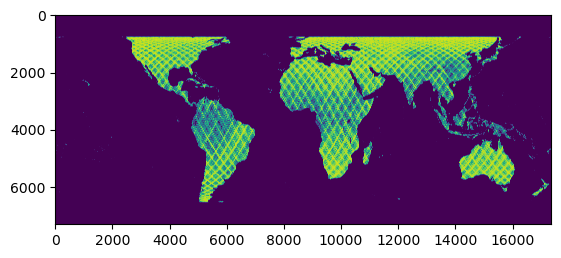

In [36]:
show_thumbnail(download_path)

## [Optional] Overlay raster layer on top of folium map

To properly visualize the canopy heights, we need to display the TIF image on the map. The TIF image file may be too memory and compute-intensive for the kernel causing the process to exit.

In [25]:
# tif=rasterio.open(download_path)
# arr=tif.read()
# bounds=tif.bounds

In [ ]:
# x1,y1,x2,y2=bounds
# bbox=[(bounds.bottom, bounds.left), (bounds.top, bounds.right)]
# m=folium.Map(location=[14.59, 120.98], zoom_start=10)
# img = folium.raster_layers.ImageOverlay(image=np.moveaxis(arr, 0, -1), bounds=bbox, opacity=0.9, interactive=True, cross_origin=False, zindex=1)
# m